<a href="https://colab.research.google.com/github/RyanSmoak/iPrevent/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import common libraries

In [1]:
!pip install optuna
!pip install hyperopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold as SKF, cross_val_score as CVS

from imblearn.over_sampling import SMOTE

import optuna
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

### Define helper functions

#### Load and EDA

In [3]:
def load_data(file_path):
    """Load dataset from a CSV file."""
    df = pd.read_csv(file_path)
    return df

In [4]:
def perform_eda(df, dataset_name=""):
    """Perform exploratory data analysis on the dataset."""
    # Basic dataset overview
    print(f"{dataset_name} First 5 Rows of Data Set:\n", df.head())
    print(f"\n{dataset_name} Information about the Data Set:\n", df.info())
    print(f"\n{dataset_name} Missing Values in the Data Set:\n", df.isnull().sum())
    print(f"\n{dataset_name} Basic Statistics:\n", df.describe())

    # Distribution of categorical variables
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for column in categorical_columns:
        plt.figure(figsize=(15, 10))
        sns.countplot(data=df, x=column)
        plt.title(f'{dataset_name} Distribution of {column}')
        plt.show()

    # Distribution of numerical variables
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns].hist(bins=15, figsize=(20, 15))
    plt.suptitle(f'{dataset_name} Distribution of numerical variables')
    plt.show()

    # Correlation matrix (DoctorInCharge column removed if present)
    if 'DoctorInCharge' in df.columns:
        df_corr = df.drop(columns=['DoctorInCharge'])
    else:
        df_corr = df.copy()
    plt.figure(figsize=(15, 10))
    sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
    plt.title(f'{dataset_name} Correlation Matrix')
    plt.show()

#### Data Cleaning

In [5]:
def handle_missing_values(df, strategy='mean'):
    """Handle missing values in numerical columns using the specified strategy (mean, median, most_frequent)."""
    imputer = SimpleImputer(strategy=strategy)
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

    # Optionally handle categorical columns (e.g., with 'most_frequent')
    categorical_columns = df.select_dtypes(include=['object']).columns
    if not categorical_columns.empty:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])
    return df

#### Data Preprocessing

In [6]:
def encode_categorical_values(df, drop_first=True):
    """One-hot encode categorical variables. Can drop the first category to avoid multi-collinearity."""
    categorical_columns = df.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(sparse_output=False, drop='first' if drop_first else None)
    encoded_columns = pd.DataFrame(encoder.fit_transform(df[categorical_columns]),
                                   columns=encoder.get_feature_names_out(categorical_columns),
                                   index=df.index)  # Ensure matching index

    # Drop original categorical columns and concatenate the encoded columns
    df = df.drop(categorical_columns, axis=1)
    df = df.drop('PatientID', axis=1)
    df = pd.concat([df, encoded_columns], axis=1)
    return df

In [7]:
from sklearn.preprocessing import PolynomialFeatures

# Creating new features
def create_new_features(df):
    # For example, we can add the product of age and BMI as a new feature
    df['Age_BMI'] = df['Age'] * df['BMI']
    return df


# Creating Polynomial Features
def add_polynomial_features(df, degree=2):
    poly = PolynomialFeatures(degree, include_bias=False)
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    poly_features = poly.fit_transform(df[numeric_columns])
    poly_feature_names = poly.get_feature_names_out(numeric_columns)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

    df = df.reset_index(drop=True)
    poly_df = poly_df.reset_index(drop=True)

    df = pd.concat([df, poly_df], axis=1)
    return df

In [8]:
def normalize_data(df):
    """Normalize numerical columns using StandardScaler (zero mean, unit variance)."""
    scaler = StandardScaler()
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

In [9]:
def scale(df):
  scaler = StandardScaler()
  df_scaled = scaler.fit_transform(df)
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
  return df_scaled

#### Worker functions

In [10]:
def save_datasets(X_train, X_test, y_train, y_test, X_cv, y_cv, output_dir):
    """Save training and testing sets to CSV files."""
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save training and testing sets to CSV files
    X_train.to_csv(os.path.join(output_dir, 'X_train.csv'), index=False)
    X_test.to_csv(os.path.join(output_dir, 'X_test.csv'), index=False)
    y_train.to_csv(os.path.join(output_dir, 'y_train.csv'), index=False)
    y_test.to_csv(os.path.join(output_dir, 'y_test.csv'), index=False)
    X_cv.to_csv(os.path.join(output_dir, 'X_cv.csv'), index=False)
    y_cv.to_csv(os.path.join(output_dir, 'y_cv.csv'), index=False)

    # Print confirmation message
    print(f"Datasets saved to {output_dir}")

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def main(data, target_column, output_dir):
    """Main function to run the data processing pipeline."""
    df = data.drop(columns=['Diagnosis'])
    df_target = data['Diagnosis']

    perform_eda(df, dataset_name="Original")
    df = handle_missing_values(df)
    df = encode_categorical_values(df)
    df = normalize_data(df)
    df = scale(df)
    if 'PatientID' in df.columns:
      df = df.drop(columns=['PatientID'])
    else:
      print("Column 'PatientID' not found in DataFrame. Skipping drop operation.")


    # Splitting data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(df, df_target, test_size=0.2, random_state=42)

    # Splitting the temporary set into cross-validation and testing sets
    X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    save_datasets(X_train, X_test, y_train, y_test, X_cv, y_cv, output_dir)

    # Convert the target variable to categorical if it's not already
    # Assuming 'Diagnosis' should be treated as a categorical variable
    y_train = y_train.astype('category')
    y_test = y_test.astype('category')
    y_cv = y_cv.astype('category')

    # Oversample the training, test and cv set
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    X_test, y_test = smote.fit_resample(X_test, y_test)
    X_cv, y_cv = smote.fit_resample(X_cv, y_cv)


    # Column analysis for training, cross-validation, and test sets
    perform_eda(pd.concat([X_train, y_train], axis=1), dataset_name="Training Set")
    perform_eda(pd.concat([X_test, y_test], axis=1), dataset_name="Test Set")
    perform_eda(pd.concat([X_cv, y_cv], axis=1), dataset_name="Cross Validation Set")

    return X_train, X_test, y_train, y_test, X_cv, y_cv

### Connect to Drive

In [16]:
#connect to drive and get data from drive
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/KamiLimu/iPrevent/diabetes_data.csv',
                   index_col= None,
                   header = 0,)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,PatientID,Age,Gender,SocioeconomicStatus,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,AntihypertensiveMedications,AntidiabeticMedications,FrequentUrination,ExcessiveThirst,UnexplainedWeightLoss,FatigueLevels,BlurredVision,SlowHealingSores,TinglingHandsFeet,Diagnosis
0,6000,44,0,2,32.985284,1,4.499365,2.443385,4.898831,4.049885,...,0,1,0,0,0,9.534169,0,0,1,1
1,6001,51,1,1,39.916764,0,1.578919,8.301264,8.941093,7.508150,...,0,0,0,0,0,0.123214,0,0,0,1
2,6002,89,1,1,19.782251,0,1.177301,6.103395,7.722543,7.708387,...,1,0,0,0,0,9.643320,0,0,0,0
3,6003,21,1,1,32.376881,1,1.714621,8.645465,4.804044,6.286548,...,0,1,0,0,0,3.403557,0,0,0,0
4,6004,27,1,1,16.808600,0,15.462549,4.629383,2.532756,9.771125,...,1,0,0,0,0,2.924687,0,0,0,0


In [13]:
#check columns
data.columns

Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'SocioeconomicStatus',
       'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption',
       'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'FamilyHistoryDiabetes', 'GestationalDiabetes',
       'PolycysticOvarySyndrome', 'PreviousPreDiabetes', 'Hypertension',
       'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c',
       'SerumCreatinine', 'BUNLevels', 'CholesterolTotal', 'CholesterolLDL',
       'CholesterolHDL', 'CholesterolTriglycerides',
       'AntihypertensiveMedications', 'Statins', 'AntidiabeticMedications',
       'FrequentUrination', 'ExcessiveThirst', 'UnexplainedWeightLoss',
       'FatigueLevels', 'BlurredVision', 'SlowHealingSores',
       'TinglingHandsFeet', 'QualityOfLifeScore', 'HeavyMetalsExposure',
       'OccupationalExposureChemicals', 'WaterQuality',
       'MedicalCheckupsFrequency', 'MedicationAdherence', 'HealthLiteracy',
       'Diagnosis', 'DoctorInCharge'],
      dtype='object')

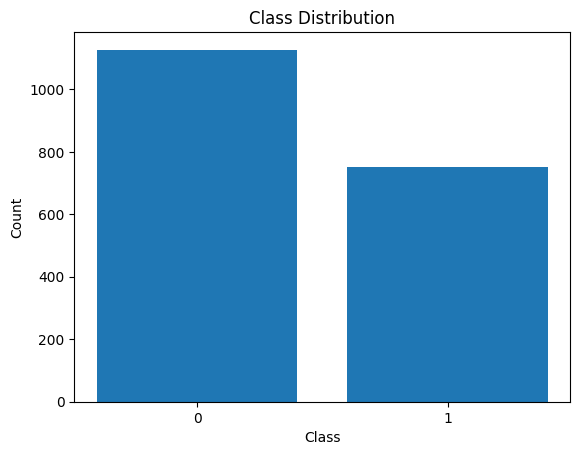

In [14]:
x=data.drop(["Diagnosis"],axis=1)
y=data["Diagnosis"]

count_class = y.value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(range(len(count_class.index)), count_class.index)
plt.show()


In [15]:
#find unique values in a column
data["Diagnosis"].unique()

array([1, 0])

### The actual Main

Original First 5 Rows of Data Set:
    PatientID  Age  Gender  SocioeconomicStatus        BMI  Smoking  \
0       6000   44       0                    2  32.985284        1   
1       6001   51       1                    1  39.916764        0   
2       6002   89       1                    1  19.782251        0   
3       6003   21       1                    1  32.376881        1   
4       6004   27       1                    1  16.808600        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0            4.499365          2.443385     4.898831      4.049885  ...   
1            1.578919          8.301264     8.941093      7.508150  ...   
2            1.177301          6.103395     7.722543      7.708387  ...   
3            1.714621          8.645465     4.804044      6.286548  ...   
4           15.462549          4.629383     2.532756      9.771125  ...   

   Hypertension  AntihypertensiveMedications  AntidiabeticMedications  \
0             0    

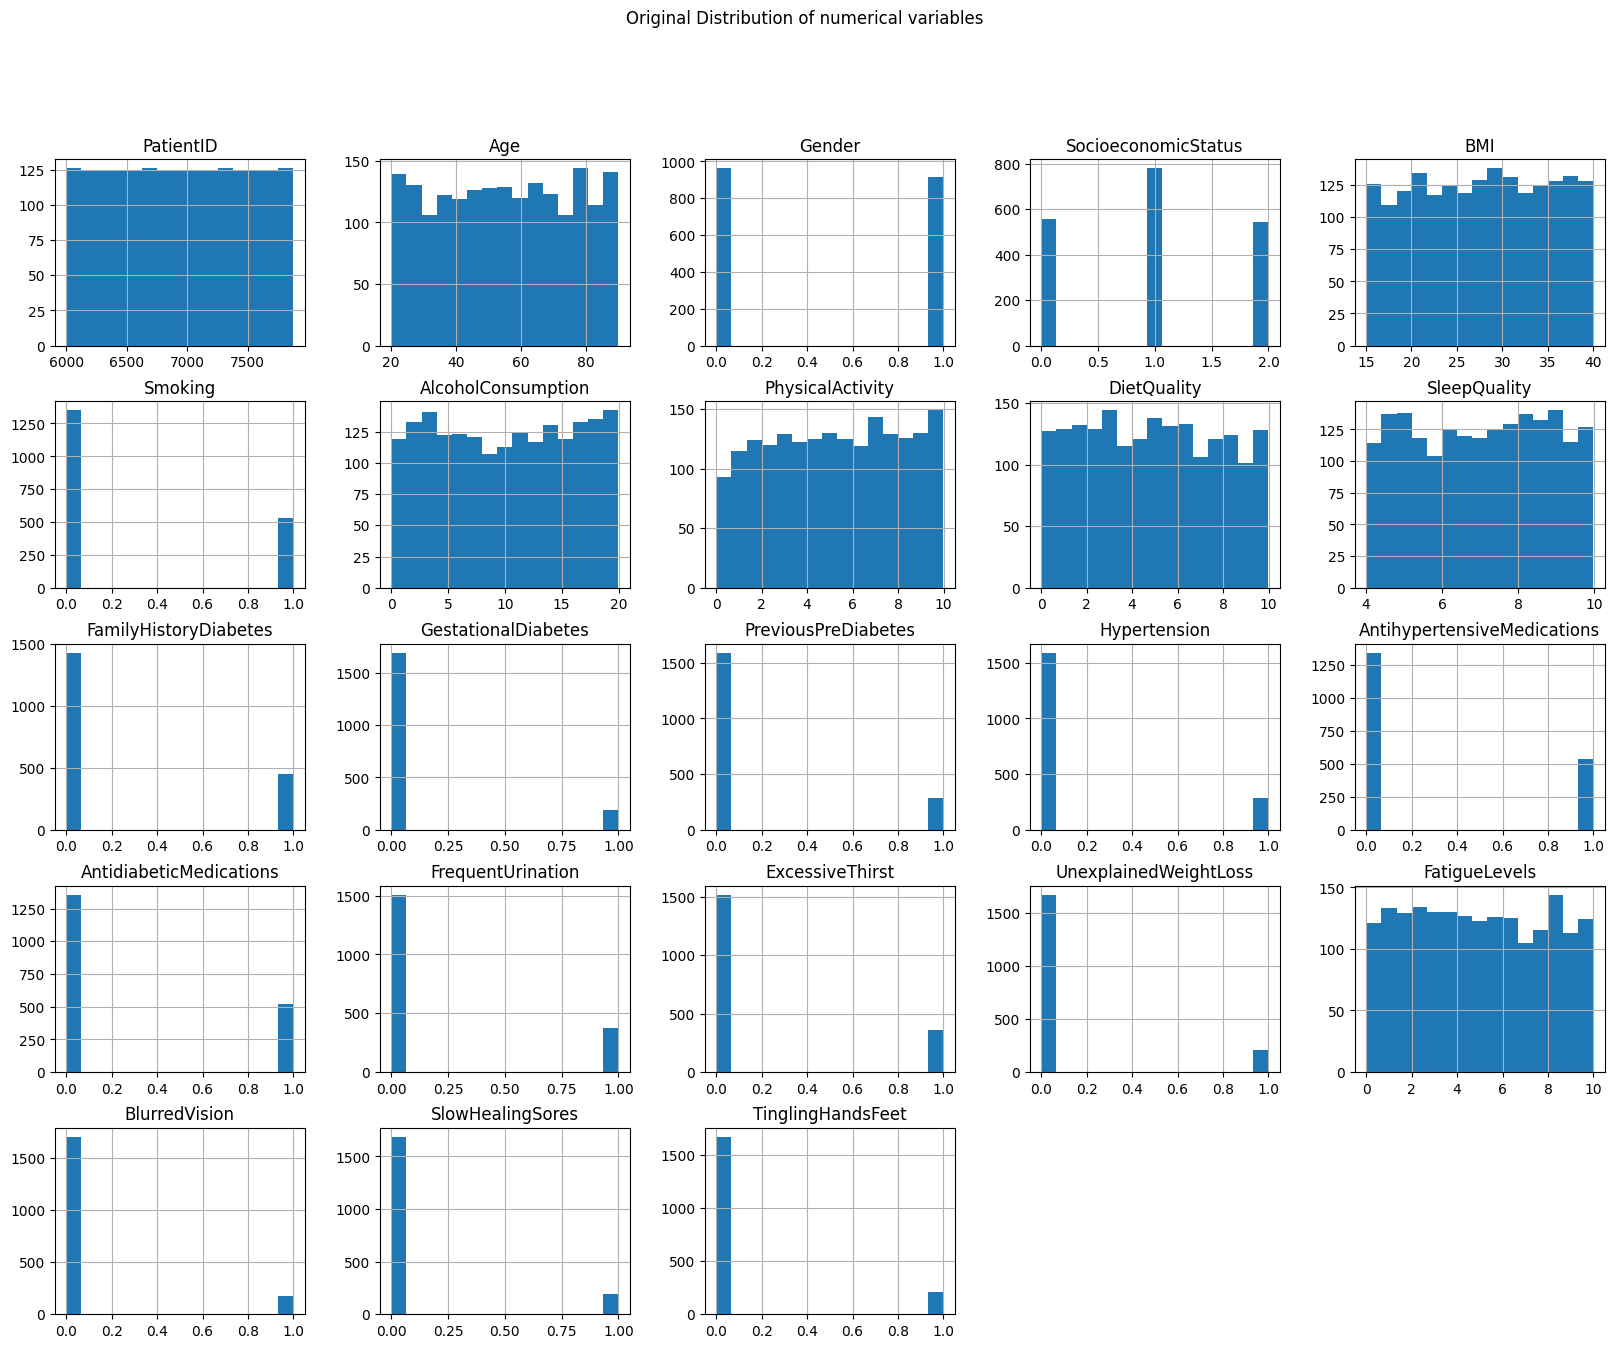

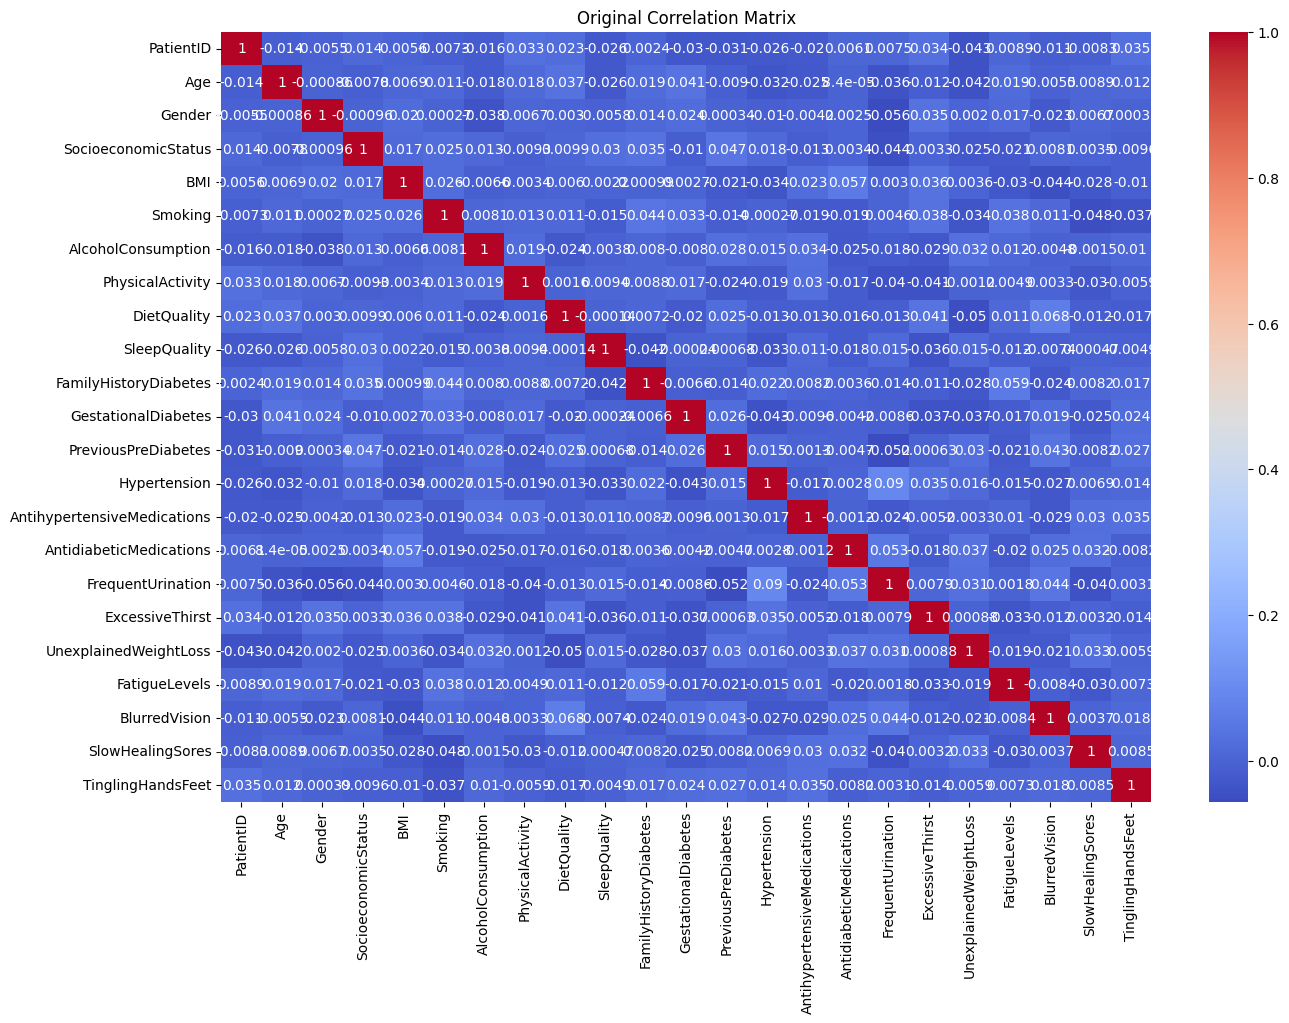

Column 'PatientID' not found in DataFrame. Skipping drop operation.
Datasets saved to /content/drive/MyDrive/KamiLimu/iPrevent
Training Set First 5 Rows of Data Set:
         Age    Gender  SocioeconomicStatus       BMI   Smoking  \
0 -0.830950  1.025334            -1.297201 -0.163232 -0.625981   
1  0.582968 -0.975292            -1.297201  1.514173 -0.625981   
2  0.826747  1.025334             1.318079 -0.464839  1.597493   
3  0.436700  1.025334             0.010439  1.690816 -0.625981   
4  0.582968 -0.975292             0.010439  0.134822 -0.625981   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  \
0           -0.994772         -1.144389    -0.182251      0.207377   
1            0.178934          0.743948     0.495548     -1.648451   
2            0.769743          1.249219    -1.046683      0.967524   
3           -0.854111         -0.571701     0.826806     -1.646671   
4            1.640885          1.622526     1.160002     -1.382019   

   FamilyHistor

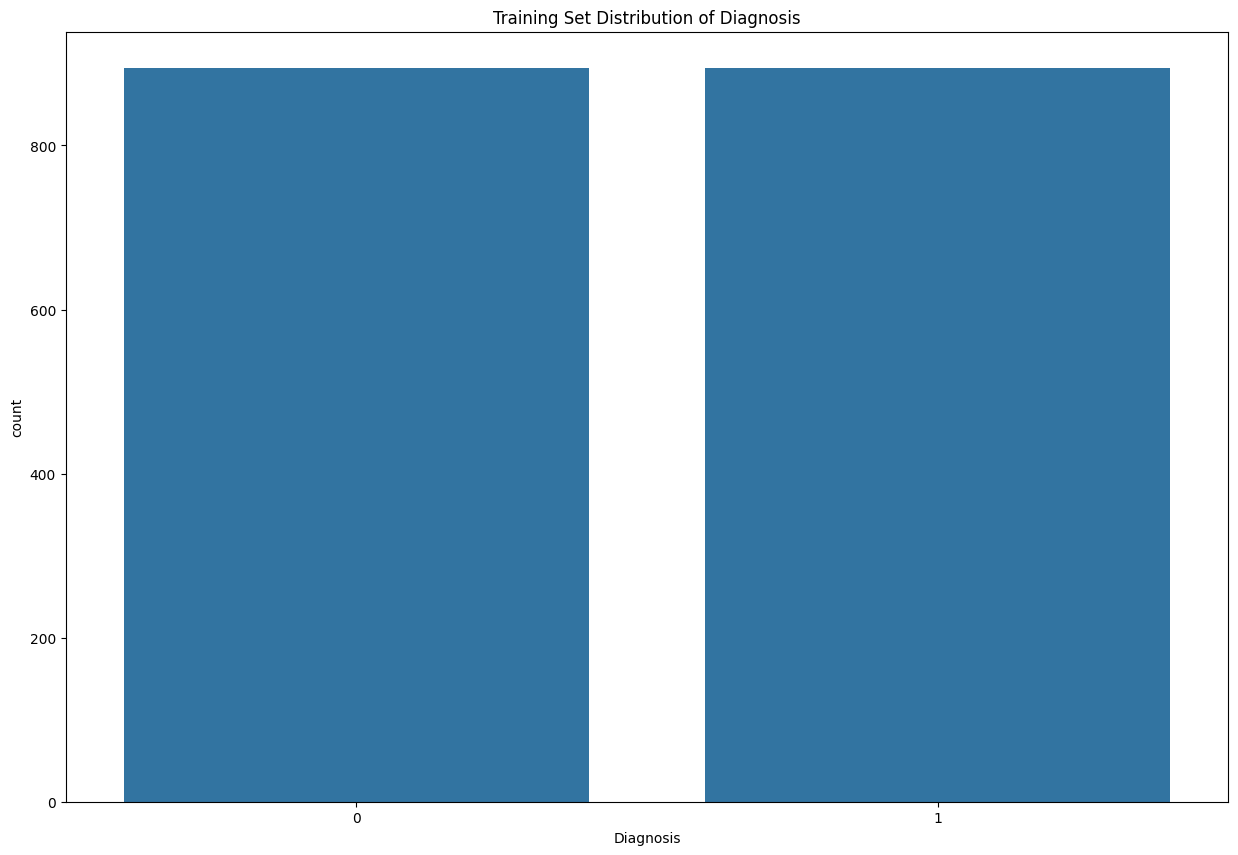

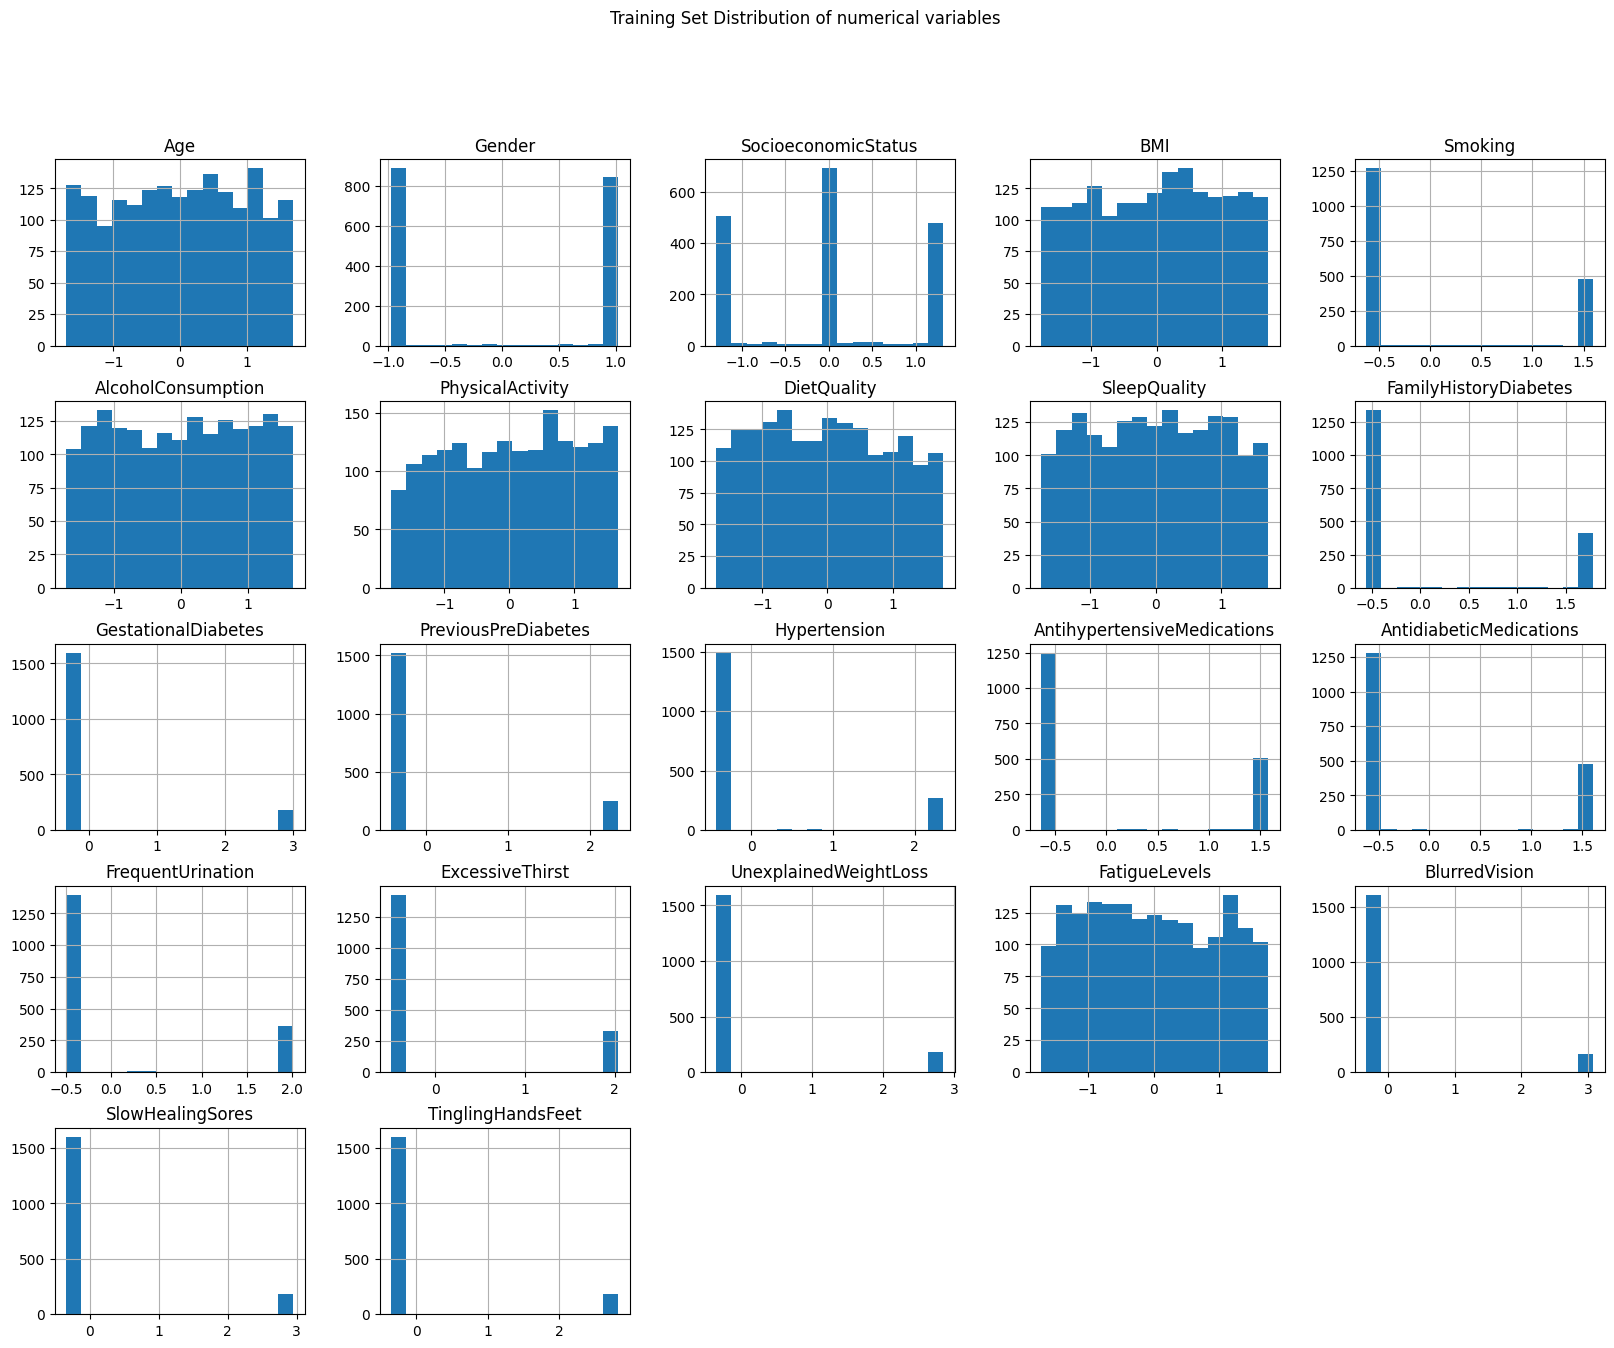

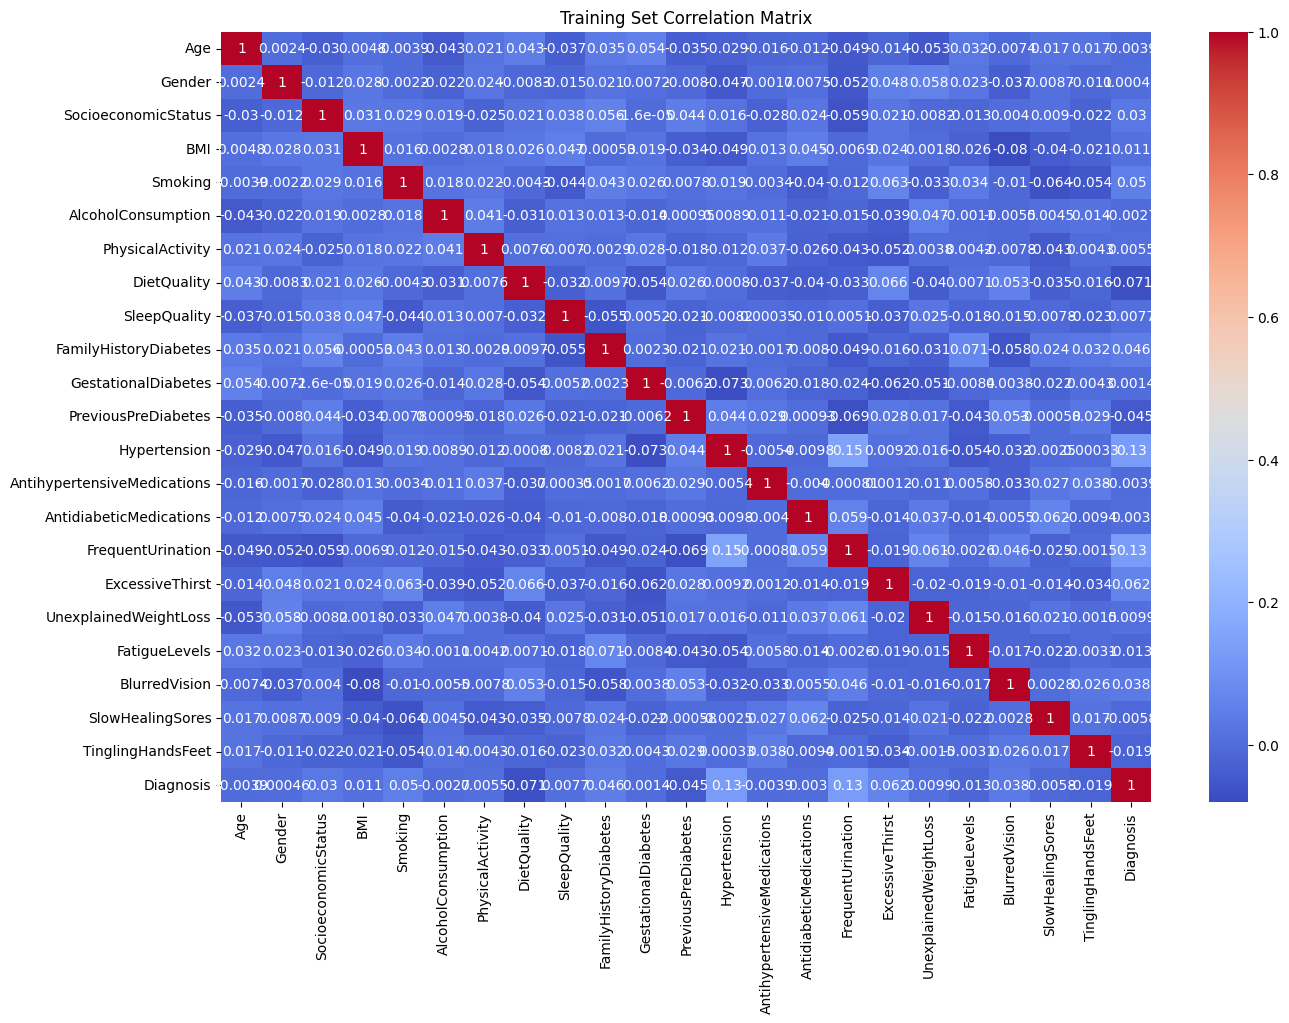

Test Set First 5 Rows of Data Set:
         Age    Gender  SocioeconomicStatus       BMI   Smoking  \
0 -1.611043 -0.975292             1.318079 -1.713407 -0.625981   
1  0.485456  1.025334            -1.297201  1.334011 -0.625981   
2 -0.587171 -0.975292             1.318079  0.658697 -0.625981   
3  0.777991 -0.975292             0.010439 -0.781408  1.597493   
4 -0.684683  1.025334             0.010439 -1.748130  1.597493   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  \
0           -1.641610         -0.093473    -1.608474     -1.417159   
1            1.604327         -0.637214     0.040568     -1.048887   
2           -0.631469         -0.157798     1.339746     -0.002278   
3            0.999119          1.369863    -0.752143     -0.362273   
4           -0.269828         -0.858443    -1.674452      0.035406   

   FamilyHistoryDiabetes  ...  AntihypertensiveMedications  \
0              -0.559525  ...                    -0.632573   
1              -0.5595

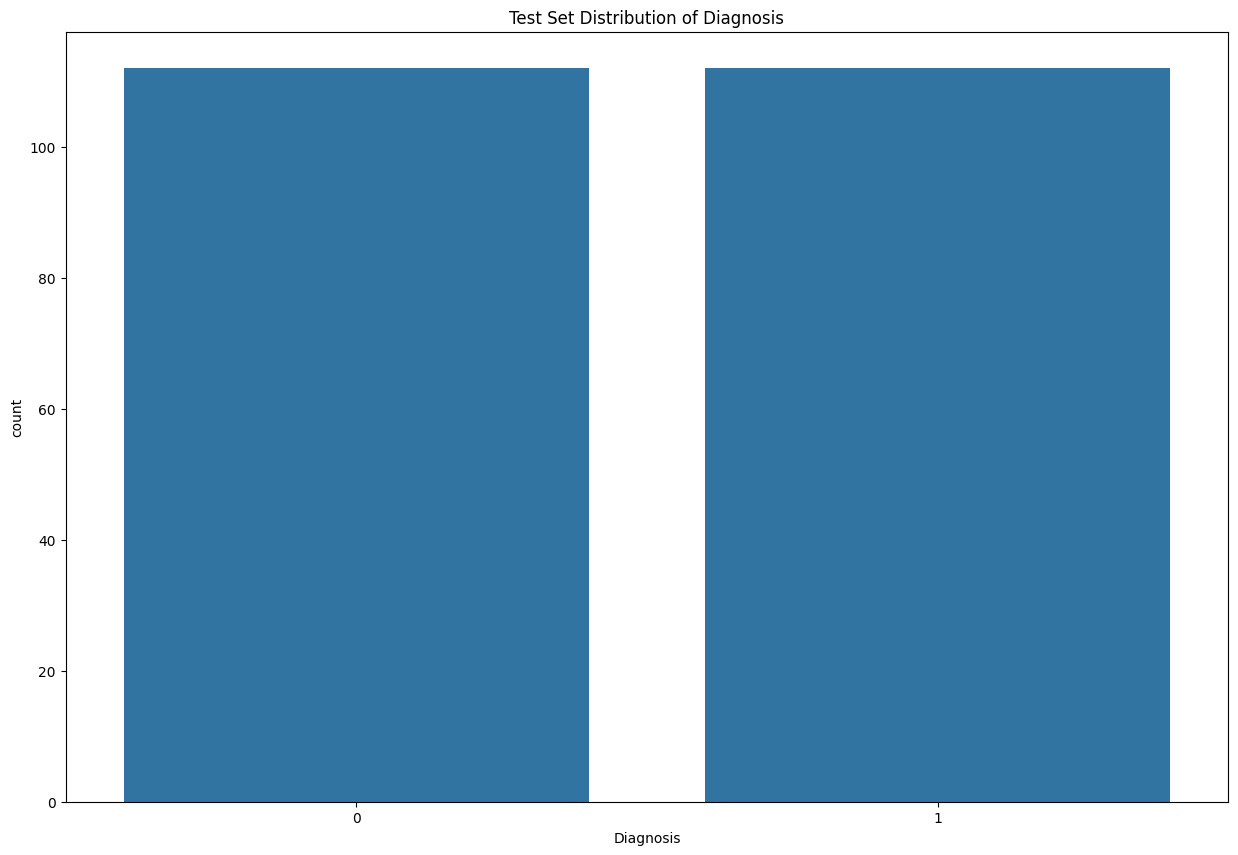

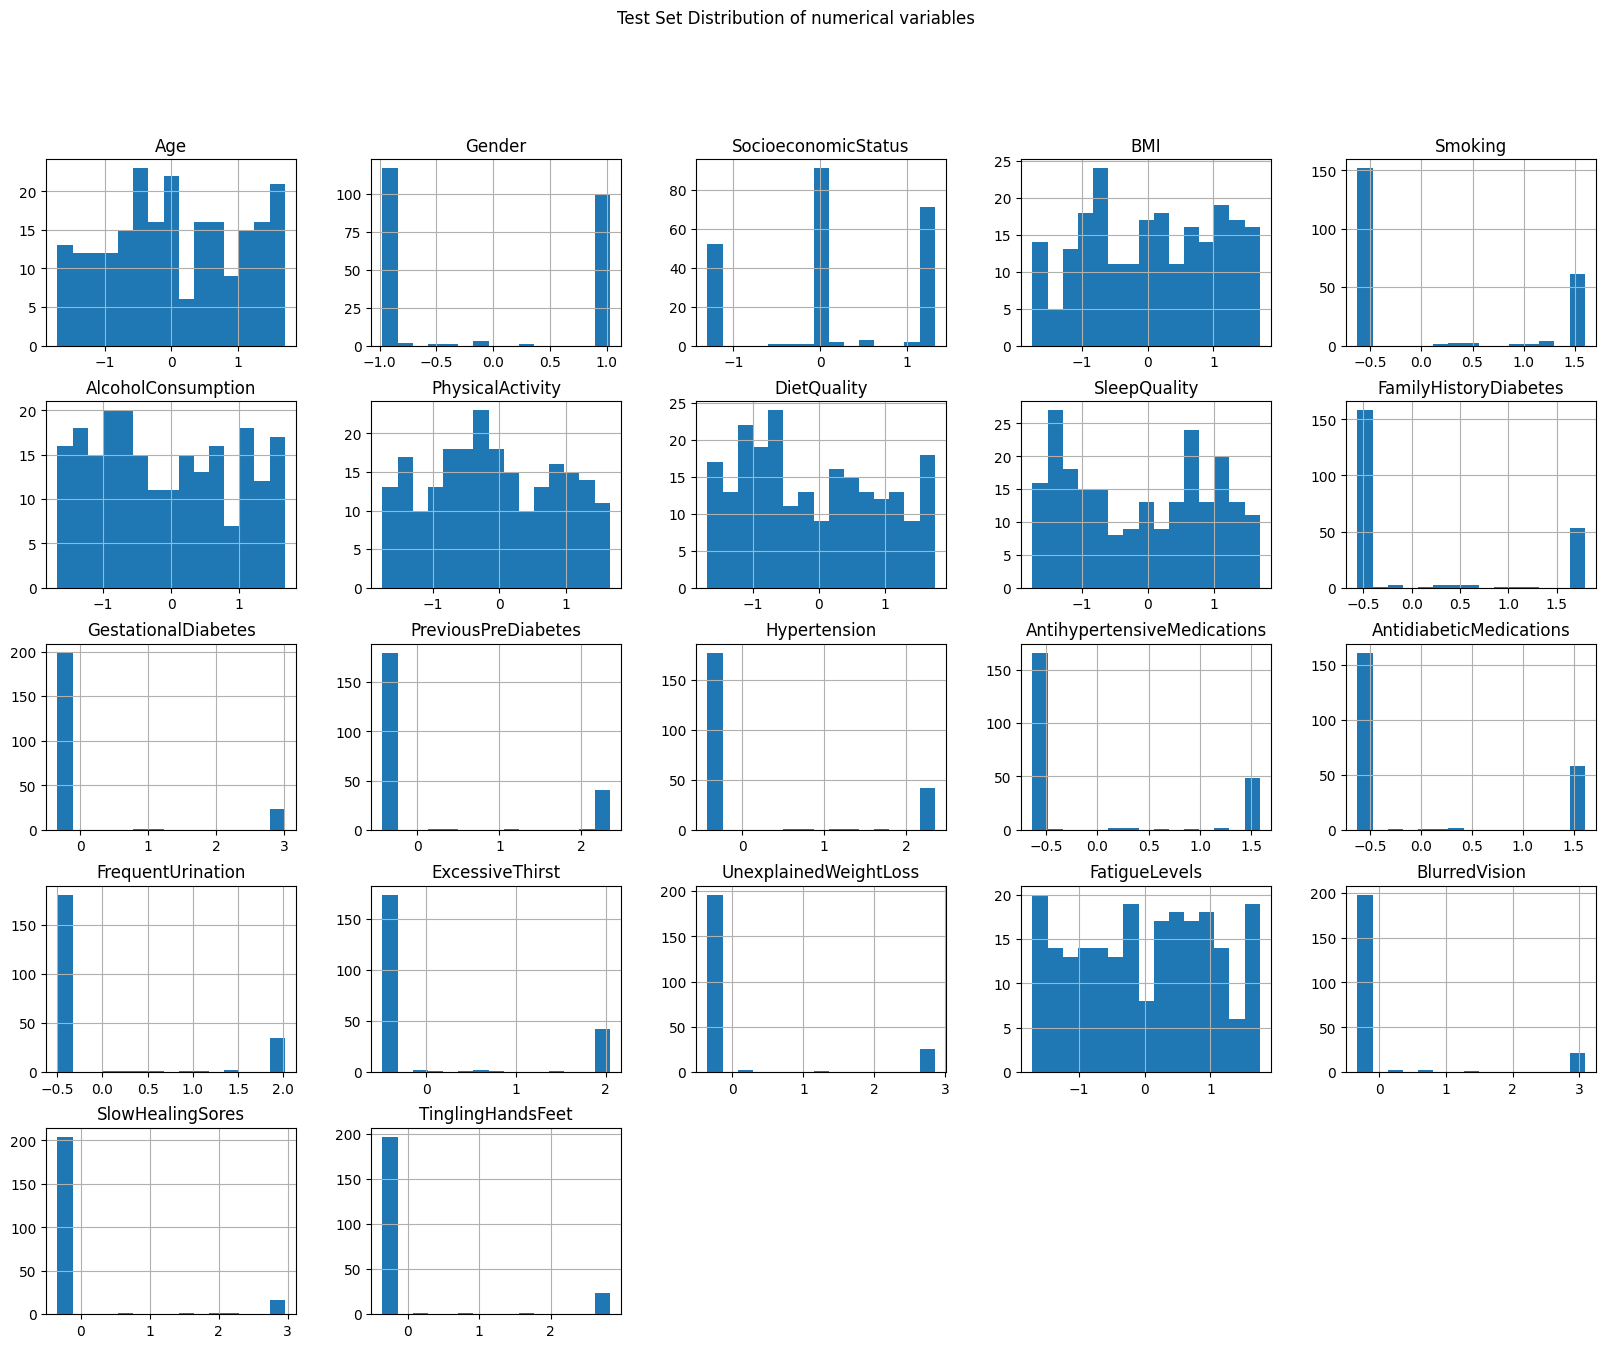

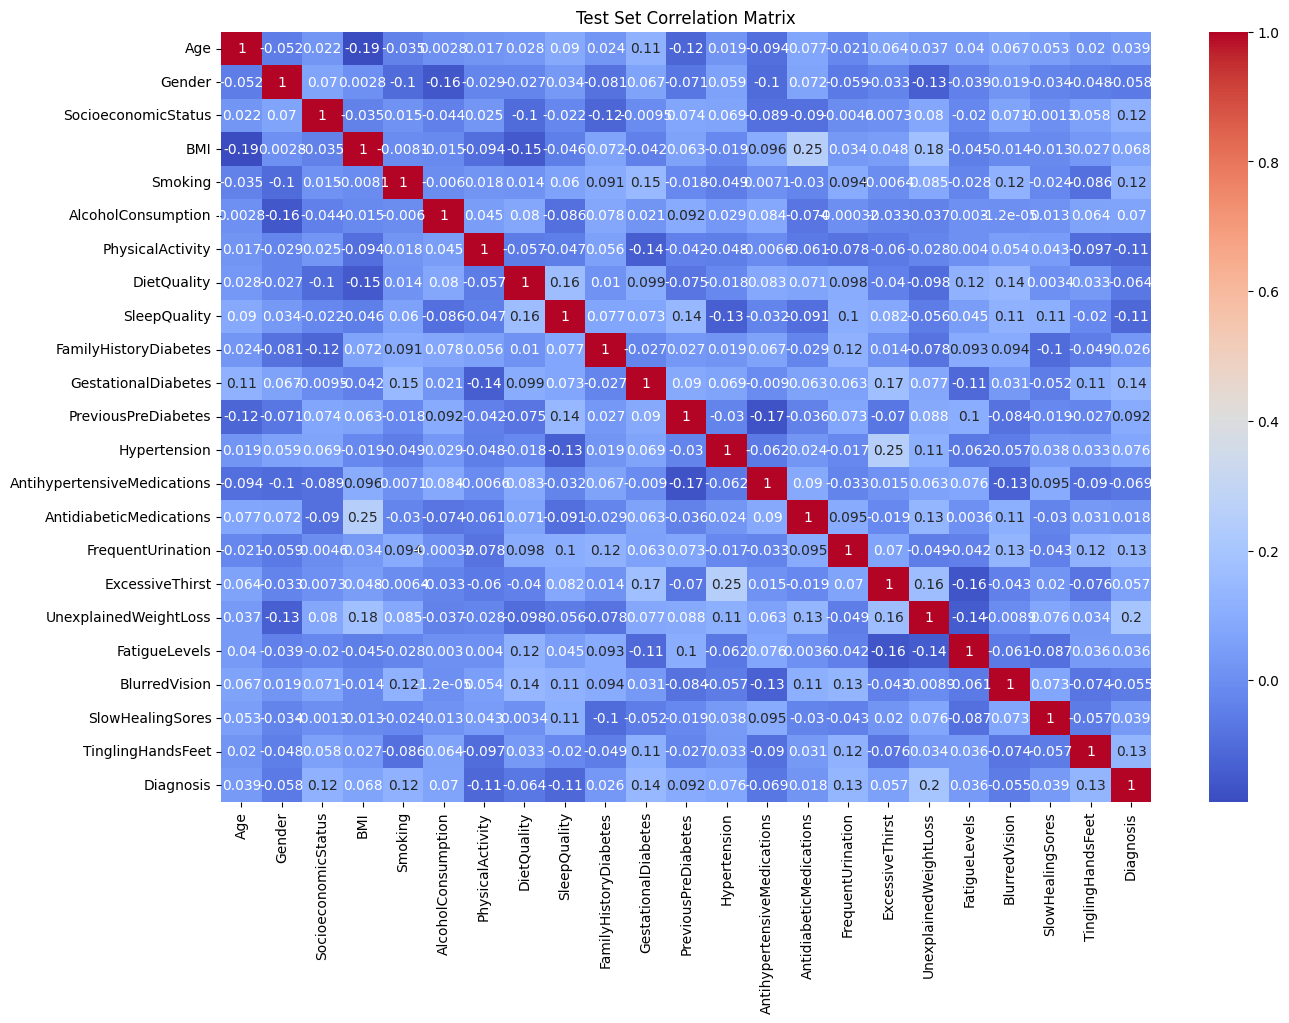

Cross Validation Set First 5 Rows of Data Set:
         Age    Gender  SocioeconomicStatus       BMI   Smoking  \
0  1.411817  1.025334             1.318079 -1.040282 -0.625981   
1 -0.294637  1.025334             0.010439 -1.351141 -0.625981   
2 -1.416020  1.025334            -1.297201 -1.710005 -0.625981   
3 -1.074729 -0.975292             0.010439 -0.664775 -0.625981   
4 -0.684683  1.025334             0.010439 -1.087061 -0.625981   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  \
0            0.463152         -0.486879     1.661308      0.919805   
1            0.411120         -0.455682     0.804789      1.206133   
2           -0.979333         -0.231802     1.139209      1.280407   
3            1.489450         -1.096893    -0.444070      1.087395   
4            0.749219         -0.565949    -0.772209      0.470665   

   FamilyHistoryDiabetes  ...  AntihypertensiveMedications  \
0              -0.559525  ...                     1.580844   
1         

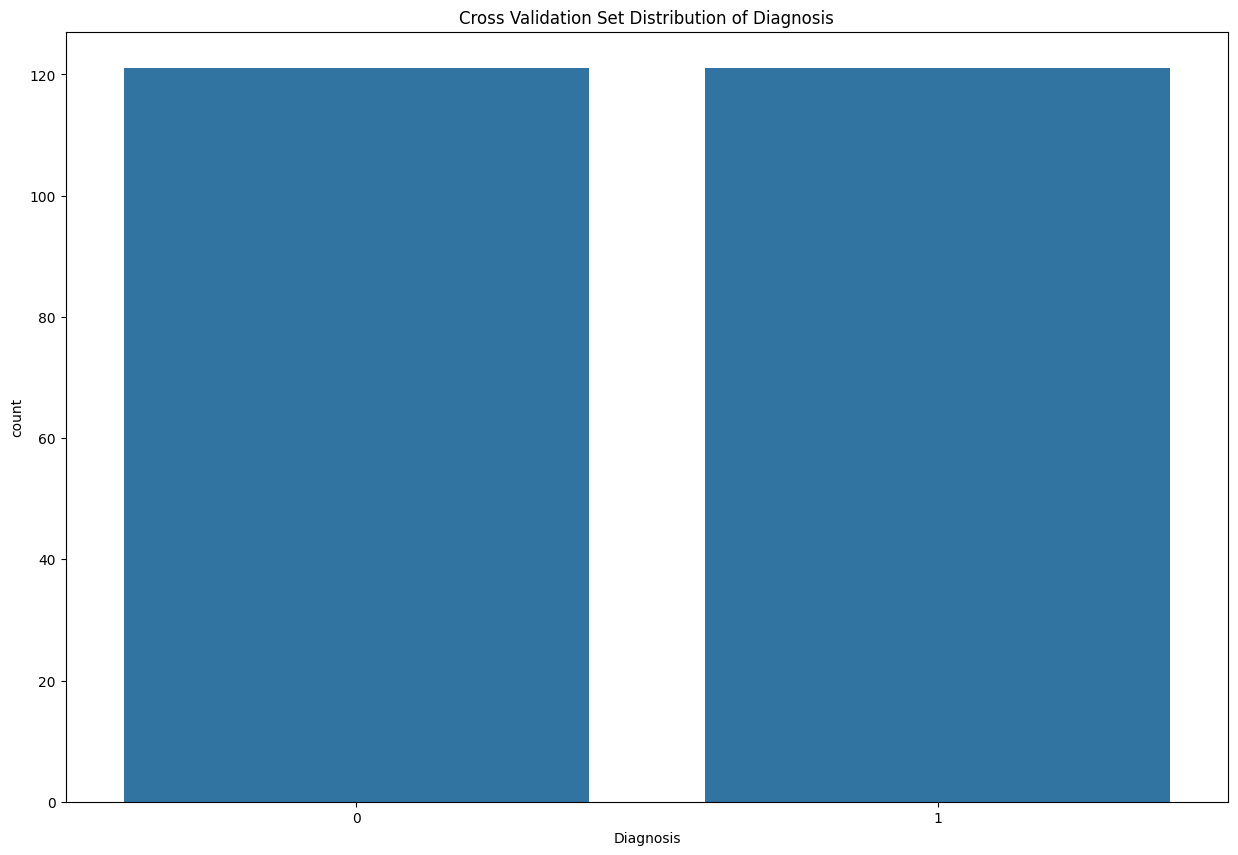

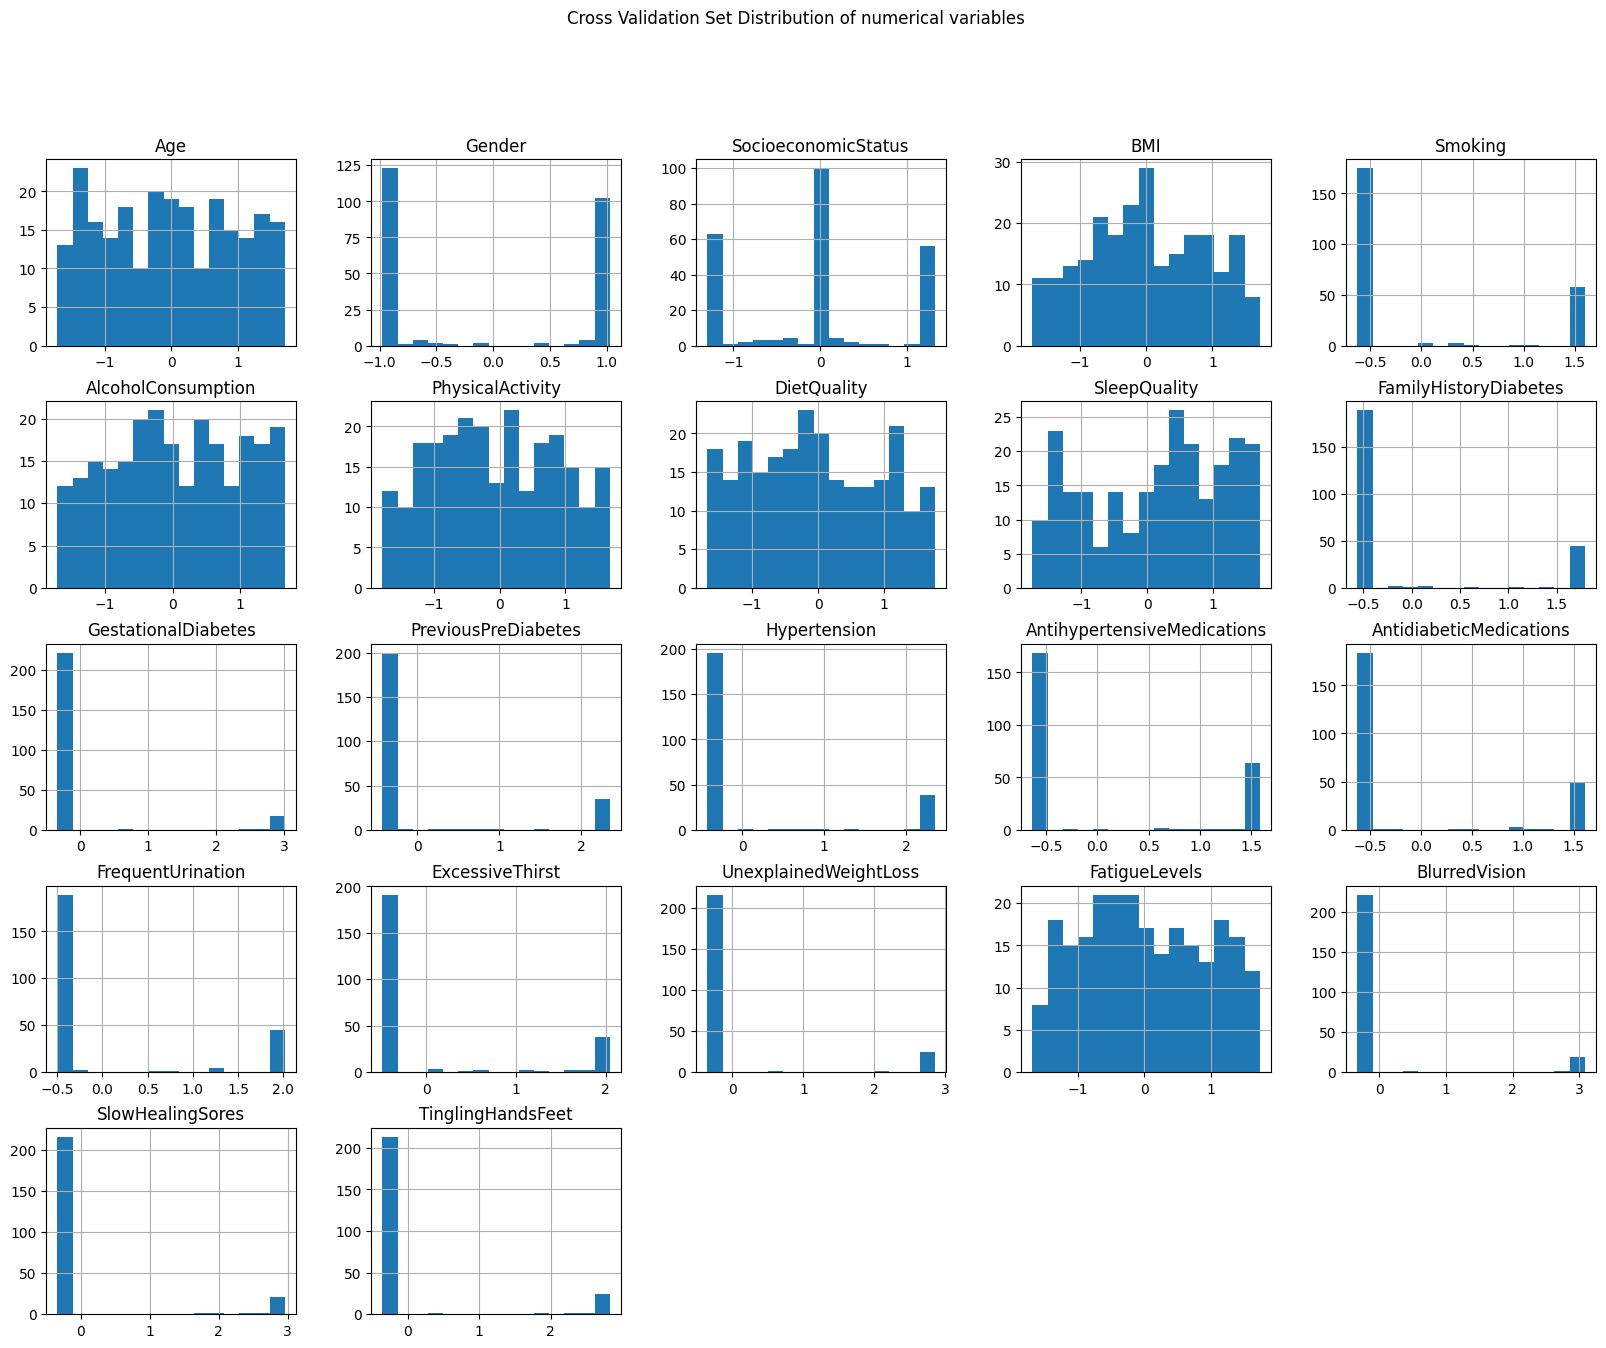

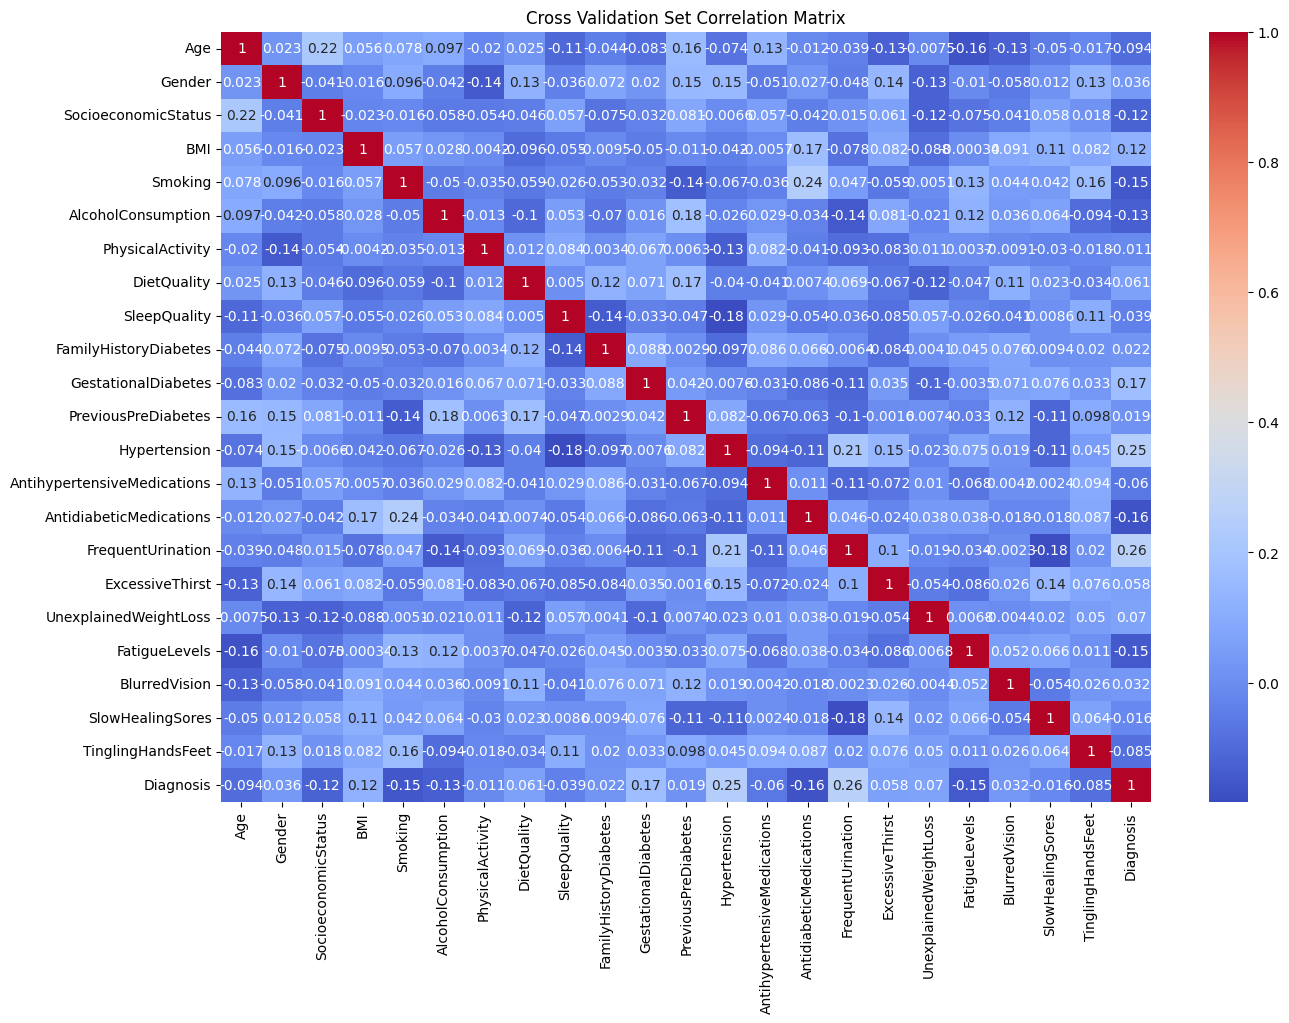

In [19]:
if __name__ == "__main__":
    target_column = "Diagnosis"  # Target variable
    output_dir = r"/content/drive/MyDrive/KamiLimu/iPrevent"  # Directory to save
    X_train, X_test, y_train, y_test, X_cv, y_cv = main(data, target_column, output_dir)

### Data Modeling

##### Random Forest

In [20]:
#importing libraries needed for the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [21]:
#create an instance of the classifier with default parameters
clf = RandomForestClassifier(random_state=42,
                             bootstrap= False,
                             max_depth=30,
                             max_features = 'sqrt',
                             min_samples_leaf= 1, min_samples_split = 2,
                             n_estimators= 200)

skf = SKF(n_splits=5, shuffle=True, random_state=42)

#fit the model
clf.fit(X_train, y_train)

feature_importances = clf.feature_importances_

# Create a DataFrame
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})

# Sort by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)
importances_df.head(10)

print(importances_df)

#make predictions on the test set
y_pred = clf.predict(X_cv)

#calculate accuracy, precision_recall, f1_score
scores = CVS(clf, X_train, y_train, cv=skf)
print(f"Cross-Validation Accuracy: {scores.mean()}")
print(f"Mean CV Accuracy: {scores.mean():.2f}")
accuracy = accuracy_score(y_cv, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_cv, y_pred, average='weighted')
print("Precision:", precision)
recall = recall_score(y_cv, y_pred, average='weighted')
print("Recall:", recall)
f1 = f1_score(y_cv, y_pred, average='weighted')
print("F1 Score:", f1)

                        feature  importance
7                   DietQuality    0.105230
8                  SleepQuality    0.104148
18                FatigueLevels    0.101664
3                           BMI    0.100704
6              PhysicalActivity    0.100164
5            AlcoholConsumption    0.098454
0                           Age    0.093921
2           SocioeconomicStatus    0.046123
15            FrequentUrination    0.028850
1                        Gender    0.024299
12                 Hypertension    0.023959
4                       Smoking    0.021267
9         FamilyHistoryDiabetes    0.020806
14      AntidiabeticMedications    0.020032
16              ExcessiveThirst    0.019437
13  AntihypertensiveMedications    0.018851
11          PreviousPreDiabetes    0.013768
21            TinglingHandsFeet    0.013223
17        UnexplainedWeightLoss    0.012369
10          GestationalDiabetes    0.011052
19                BlurredVision    0.010987
20             SlowHealingSores 

In [22]:
importances_df.head(10)

,feature,importance
7,DietQuality,0.105230
8,SleepQuality,0.104148
18,FatigueLevels,0.101664
3,BMI,0.100704
6,PhysicalActivity,0.100164
5,AlcoholConsumption,0.098454
0,Age,0.093921
2,SocioeconomicStatus,0.046123
15,FrequentUrination,0.028850
1,Gender,0.024299


In [16]:
#import gridsearchcv
from sklearn.model_selection import GridSearchCV

#create parameter grid for searching
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#create an object of gridsearchcv
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)

#fit the model
grid_search.fit(X_train, y_train)

print(f"Best parameters include: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

KeyboardInterrupt: 

In [ ]:
#import randomizedsearchcv
from sklearn.model_selection import RandomizedSearchCV as RCV
import numpy as np

#create parameter dist for searching
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.001, 0.01, 0.1, 0.05, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'loss': ['deviance', 'exponential'],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1]
}

#create an object of rcv
random_search = RCV(estimator=gbm,
                    param_distributions=param_dist,
                    n_iter = 100, cv=5,
                    random_state= 42, n_jobs=-1)

#fit the model
random_search.fit(X_train, y_train)

print(f"Best parameters include: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
415 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Best parameters include: {'subsample': 0.7, 'n_estimators': 900, 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.05, 'max_features': 'sqrt', 'max_depth': 7, 'loss': 'exponential', 'learning_rate': 0.01, 'criterion': 'friedman_mse'}
Best score: 0.6639578736522541


In [42]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(params):
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    min_samples_split = int(params['min_samples_split'])
    min_samples_leaf = int(params['min_samples_leaf'])
    bootstrap = params['bootstrap']

    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    return {'loss': 1 - scores.mean(), 'status': STATUS_OK}

In [43]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

In [44]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print("Best parameters found: ", best)
print("Best cross-validation score: ", 1 - trials.best_trial['result']['loss'])

100%|██████████| 100/100 [05:43<00:00,  3.44s/trial, best loss: 0.3198253603117225]
Best parameters found:  {'bootstrap': 1, 'max_depth': 10.0, 'min_samples_leaf': 1.0, 'min_samples_split': 6.0, 'n_estimators': 200.0}
Best cross-validation score:  0.6801746396882775


##### XGBoost

In [23]:
#import libraries for XGBoost and stacking
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [35]:
#create an instance of the xgboost
xgb = XGBClassifier(eval_metric='mlogloss',
                    n_estimators = 150, max_depth = 3,
                    learning_rate = 0.0350301845605717,
                    subsample = 0.8122597940758953,
                    colsample_bytree = 0.8463962105548805,
                    min_child_weight = 6,
                    gamma = 0.27131037264162033,
                    random_state=42)

#fit the model
xgb.fit(X_train, y_train)

#make prediction on the test set
y_pred_xgb = xgb.predict(X_test)

#calculate accuracy, precision_recall, f1_score
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.65625


In [ ]:
#import randomizedsearchcv
from sklearn.model_selection import RandomizedSearchCV as RCV
import numpy as np

#create parameter dist for searching
param_grid = {
    'n_estimators': np.arange(50, 200, 50),
    'max_depth': np.arange(3, 10, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'min_child_weight': np.arange(1, 10, 1),
    'gamma': np.linspace(0, 0.5, 10)
}

#create an object of rcv
random_search = RCV(estimator=xgb,
                    param_distributions=param_grid,
                    n_iter = 100, cv=5,
                    random_state= 42, n_jobs=-1)

#fit the model
random_search.fit(X_train, y_train)

print(f"Best parameters include: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters include: {'subsample': 0.9444444444444444, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1711111111111111, 'gamma': 0.16666666666666666, 'colsample_bytree': 0.5555555555555556}
Best score: 0.6527518269877783


In [25]:
def obj_fun(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators',
                                     100, 200)
    max_depth = trial.suggest_int('max_depth',
                                  3, 10)
    learning_rate = trial.suggest_float('learning_rate',
                                        0.01, 0.3)
    subsample = trial.suggest_float('subsample',
                                    0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree',
                                           0.5, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight',
                                         1, 10)
    gamma = trial.suggest_float('gamma',
                                0, 0.5)

    # Train the model
    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, min_child_weight=min_child_weight, gamma=gamma, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    accuracy = model.score(X_test, y_test)
    return -accuracy  # Negative accuracy to minimize

In [26]:
import optuna

study = optuna.create_study(direction='minimize')
study.optimize(obj_fun, n_trials=100, n_jobs=-1)

[I 2024-10-20 08:51:53,899] A new study created in memory with name: no-name-f0ba6aca-90f6-4185-a9dd-c6ed4bfef45f
[I 2024-10-20 08:51:54,290] Trial 1 finished with value: -0.5758928571428571 and parameters: {'n_estimators': 135, 'max_depth': 5, 'learning_rate': 0.052505864018083555, 'subsample': 0.6363448958403044, 'colsample_bytree': 0.9950081752458362, 'min_child_weight': 10, 'gamma': 0.12479448092239925}. Best is trial 1 with value: -0.5758928571428571.
[I 2024-10-20 08:51:54,530] Trial 0 finished with value: -0.5848214285714286 and parameters: {'n_estimators': 144, 'max_depth': 7, 'learning_rate': 0.2763717157639052, 'subsample': 0.5884118613156399, 'colsample_bytree': 0.9348230313114153, 'min_child_weight': 4, 'gamma': 0.43524252598478386}. Best is trial 0 with value: -0.5848214285714286.
[I 2024-10-20 08:51:54,833] Trial 2 finished with value: -0.5982142857142857 and parameters: {'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.08015760997920923, 'subsample': 0.70419665970

In [27]:
print(f"Best parameters found: {study.best_params}")
print(f"Best score found: {study.best_value}")

Best parameters found: {'n_estimators': 117, 'max_depth': 4, 'learning_rate': 0.01473463126626653, 'subsample': 0.8887165751797635, 'colsample_bytree': 0.9478504130760466, 'min_child_weight': 8, 'gamma': 0.15543918520535038}
Best score found: -0.6696428571428571


##### GBMClassifier

In [36]:
#import gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

X_cv = X_cv[X_train.columns]

#create an instance of the gradient boosting classifier
gbm = GradientBoostingClassifier(subsample=0.7, n_estimators=900,
                                 min_samples_leaf= 2,
                                 min_impurity_decrease=0.05,
                                 max_features='sqrt', max_depth=7,
                                 loss='exponential',
                                 learning_rate=0.01,
                                 criterion='friedman_mse')

#fit the model
gbm.fit(X_train, y_train)

#make prediction on the test set
y_pred_gbm = gbm.predict(X_test)

#calculate accuracy, precision_recall, f1
accuracy = accuracy_score(y_test, y_pred_gbm)
print("Accuracy:", accuracy)

Accuracy: 0.5714285714285714


In [83]:
#optuna to tune GBM
def obj_fun_gbm(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1),
    }

    #Define and fit the GBM model
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)

    # Evaluate the model
    accuracy = model.score(X_test, y_test)
    return -accuracy  # Negative accuracy to minimize

In [84]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(obj_fun_gbm, n_trials=100)

# Get the best trial
best_trial = study.best_trial

print(f"Best trial: {best_trial.params}")
print(f"Best accuracy: {best_trial.value}")

[I 2024-10-16 18:26:28,117] A new study created in memory with name: no-name-d0531218-aeb8-4d3c-9b11-3d6a8ec36a5e
<ipython-input-83-f99a82a15c2f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-10-16 18:26:29,849] Trial 0 finished with value: -0.5 and parameters: {'n_estimators': 961, 'learning_rate': 0.018075251985629544, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 20, 'subsample': 0.839654428276609, 'max_features': 'sqrt', 'criterion': 'squared_error', 'min_impurity_decrease': 0.06159344093649477}. Best is trial 0 with value: -0.5.
<ipython-input-83-f99a82a15c2f>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

Best trial: {'n_estimators': 961, 'learning_rate': 0.018075251985629544, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 20, 'subsample': 0.839654428276609, 'max_features': 'sqrt', 'criterion': 'squared_error', 'min_impurity_decrease': 0.06159344093649477}
Best accuracy: -0.5


In [87]:
#LightGBM
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lgbm)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 894, number of negative: 894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 1788, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.5714285714285714


In [ ]:
#tuning LGBM with randomizedsearchCV

## Ensemble learning

#### Stacking Models

##### Stacking GBM with Random Forest

In [37]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression as LR

estimators = [
    ('gbm', gbm),
    ('rf', clf)
]

stacked_model_gbm = StackingClassifier(estimators=estimators, final_estimator=LR())

stacked_model_gbm.fit(X_train, y_train)

predictions = stacked_model_gbm.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.625


##### Stacking Random Forest with XGBoost

In [39]:
estimators = [
    ('xgb', xgb), ('rf', clf)
]

stacked_model_xgb = StackingClassifier(estimators=estimators, final_estimator=LR())

stacked_model_xgb.fit(X_train, y_train)

predictions = stacked_model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.59375


#### Boosting Random Forest

In [46]:
from sklearn.ensemble import AdaBoostClassifier as ABC

rf = clf
ada_rf = ABC(estimator=rf, n_estimators=217, learning_rate=0.08756305431708288, algorithm='SAMME')

skf = SKF(n_splits=5, shuffle=True, random_state=42)

scores = CVS(ada_rf, X_train, y_train, cv=skf)
print(f"Cross-Validation Accuracy: {scores.mean()}")
print(f"Mean CV Accuracy: {scores.mean():.2f}")

Cross-Validation Accuracy: 0.6884809789837723
Mean CV Accuracy: 0.69


##### Tuning ADA booster

##### Optuna

In [40]:
import optuna

def obj_fun_ada(trial, clf):
  n_estimators = trial.suggest_int('n_estimators', 50, 1000)
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.3)
  algorithm = trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R'])
  rf = clf
  ada = ABC(estimator=rf, n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm)
  scores = CVS(ada, X_train, y_train, cv=skf, scoring='accuracy')
  return scores.mean()

In [41]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial: obj_fun_ada(trial, clf), n_trials=100)

# Get the best trial
best_trial = study.best_trial

print(f"Best trial: {best_trial.params}")
print(f"Best accuracy: {best_trial.value}")

[I 2024-10-20 09:07:51,965] A new study created in memory with name: no-name-20dffe20-935b-434b-bea5-ed00ea5be0d0
<ipython-input-40-d0def33abde0>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.3)
[I 2024-10-20 09:08:01,648] Trial 0 finished with value: 0.6884715897532196 and parameters: {'n_estimators': 679, 'learning_rate': 0.05820970408105898, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.6884715897532196.
<ipython-input-40-d0def33abde0>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.3)
/usr/local/lib/python3.10/dist-packages

Best trial: {'n_estimators': 527, 'learning_rate': 0.0011938479017308517, 'algorithm': 'SAMME'}
Best accuracy: 0.7002159523027089


##### Hyperopt

In [42]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import numpy as np

def obj_hyp_ada(params, clf):
  n_estimators = int(params['n_estimators'])
  learning_rate = params['learning_rate']
  algorithm = params['algorithm']

  rf = clf
  ada = ABC(estimator=rf, n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm)
  scores = CVS(ada, X_train, y_train, cv=skf, scoring='accuracy').mean()

  return {'loss': -scores, 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'algorithm': hp.choice('algorithm', ['SAMME', 'SAMME.R'])
}

trials = Trials()
best = fmin(fn=lambda params: obj_hyp_ada(params, clf), space=space, algo=tpe.suggest, max_evals=200, trials=trials)

  0%|          | 1/200 [00:07<26:27,  7.98s/trial, best loss: -0.6795236530366336]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

  2%|▏         | 4/200 [00:32<26:47,  8.20s/trial, best loss: -0.6828787380874137]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

  2%|▎         | 5/200 [00:39<25:33,  7.86s/trial, best loss: -0.685679858535593] 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

  4%|▍         | 8/200 [01:01<23:20,  7.29s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

  6%|▌         | 11/200 [01:22<22:58,  7.29s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

  6%|▋         | 13/200 [01:37<22:53,  7.35s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

  7%|▋         | 14/200 [01:44<22:04,  7.12s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

  8%|▊         | 15/200 [01:51<22:28,  7.29s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

  8%|▊         | 17/200 [02:06<22:08,  7.26s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

  9%|▉         | 18/200 [02:12<21:16,  7.02s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 10%|▉         | 19/200 [02:20<22:02,  7.31s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 22%|██▏       | 43/200 [05:12<18:53,  7.22s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 22%|██▎       | 45/200 [05:26<18:20,  7.10s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 24%|██▎       | 47/200 [05:40<18:09,  7.12s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 25%|██▌       | 50/200 [06:05<19:02,  7.62s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 26%|██▋       | 53/200 [06:26<18:01,  7.36s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 28%|██▊       | 56/200 [06:48<17:38,  7.35s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 30%|███       | 60/200 [07:18<17:12,  7.37s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 32%|███▏      | 64/200 [07:46<16:33,  7.31s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 40%|████      | 81/200 [09:48<14:10,  7.15s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 43%|████▎     | 86/200 [10:23<13:27,  7.08s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 45%|████▌     | 90/200 [10:52<13:00,  7.09s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 48%|████▊     | 95/200 [11:28<12:38,  7.22s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 50%|████▉     | 99/200 [11:57<12:11,  7.25s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 52%|█████▏    | 104/200 [12:32<11:13,  7.02s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 55%|█████▌    | 110/200 [13:15<10:30,  7.00s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 57%|█████▊    | 115/200 [13:51<10:10,  7.19s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 60%|██████    | 120/200 [14:26<09:24,  7.05s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 62%|██████▎   | 125/200 [15:02<08:51,  7.08s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 65%|██████▌   | 130/200 [15:39<08:41,  7.45s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 68%|██████▊   | 135/200 [16:15<07:47,  7.20s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 70%|███████   | 141/200 [16:59<07:00,  7.14s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 82%|████████▏ | 163/200 [19:38<04:23,  7.11s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 84%|████████▍ | 169/200 [20:21<03:45,  7.26s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



 87%|████████▋ | 174/200 [20:56<03:02,  7.02s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 90%|█████████ | 180/200 [21:39<02:21,  7.07s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 93%|█████████▎| 186/200 [22:22<01:38,  7.02s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 96%|█████████▌| 192/200 [23:05<00:56,  7.09s/trial, best loss: -0.7002269064050202]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 96%|█████████▋| 193/200 [23:12<00:49,  7.11s/trial, best loss: -0.7013520491995682]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 97%|█████████▋| 194/200 [23:20<00:43,  7.17s/trial, best loss: -0.7013520491995682]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 98%|█████████▊| 195/200 [23:27<00:35,  7.06s/trial, best loss: -0.7013520491995682]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 98%|█████████▊| 196/200 [23:34<00:28,  7.20s/trial, best loss: -0.7013520491995682]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 98%|█████████▊| 197/200 [23:41<00:21,  7.07s/trial, best loss: -0.7013520491995682]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

 99%|█████████▉| 198/200 [23:48<00:14,  7.19s/trial, best loss: -0.7013520491995682]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

100%|█████████▉| 199/200 [23:55<00:07,  7.02s/trial, best loss: -0.7013520491995682]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

/usr/local/lib/pytho

100%|██████████| 200/200 [24:03<00:00,  7.22s/trial, best loss: -0.7013520491995682]


In [43]:
print(f"Best parameters found: {best}")
print(f"Best cross-validation score: {-trials.best_trial['result']['loss']}")

Best parameters found: {'algorithm': 1, 'learning_rate': 0.08756305431708288, 'n_estimators': 217.0}
Best cross-validation score: 0.7013520491995682


## Feature Selection

Let's try selecting best features using Boruta to see if maybe, just maybe, the algorithm will get better

In [45]:
!pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.5 MB/s eta 0:00:00


In [49]:
from boruta import BorutaPy

model = ada_rf

boruta = BorutaPy(model,
                  n_estimators = 500,
                  verbose = 2,
                  random_state = 42)

if X_train.select_dtypes(include=['category']).shape[1] > 0:
  X_train_encoded = pd.get_dummies(X_train, columns=X_train.select_dtypes(include=['category']).columns.tolist())  # One-hot encode categorical columns
  X_train_num = X_train_encoded.values
else:
  X_train_num = X_train.values

y_train_num = y_train.values.astype(np.int64)

boruta.fit(X_train_num, y_train_num)

if 'X_train_encoded' in locals():
  selected_feature_indices = boruta.support_
  selected_features = X_train_encoded.columns[selected_feature_indices].tolist()
else:
  selected_features = X_train.columns[boruta.support_].tolist()

selected_features = X_train.columns[boruta.support_].tolist()
print(selected_features)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	17
I

In [50]:
print(f"Original columns: {X_train.columns}")

Original columns: Index(['Age', 'Gender', 'SocioeconomicStatus', 'BMI', 'Smoking',
       'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'FamilyHistoryDiabetes', 'GestationalDiabetes', 'PreviousPreDiabetes',
       'Hypertension', 'AntihypertensiveMedications',
       'AntidiabeticMedications', 'FrequentUrination', 'ExcessiveThirst',
       'UnexplainedWeightLoss', 'FatigueLevels', 'BlurredVision',
       'SlowHealingSores', 'TinglingHandsFeet'],
      dtype='object')


In [52]:
#let's try training the boosted rf with the features given by Boruta
X_train_boruta = X_train.drop(columns=[col for col in X_train.columns if col not in selected_features])


ada_rf = ABC(estimator=rf, n_estimators=217, learning_rate=0.08756305431708288, algorithm='SAMME')

skf = SKF(n_splits=5, shuffle=True, random_state=42)

scores = CVS(ada_rf, X_train_boruta, y_train, cv=skf)
print(f"Cross-Validation Accuracy: {scores.mean()}")
print(f"Mean CV Accuracy: {scores.mean():.2f}")

Cross-Validation Accuracy: 0.5687542055928516
Mean CV Accuracy: 0.57


Seems Boruta's list of features isn't as good. The accuracy has dropped from .701 all the way to .568. Not good at all. Let's stick to working with the features as before.

## Explaining values

Seeing as Boruta has confirmed that we can't drop any other features and we can't add features, we will stick to the random forest boosted with ADA.

For now, we will use SHAP to explain the prediction, we get.

In [57]:
import shap

ada_rf.fit(X_train, y_train)

X_sample = shap.utils.sample(X_train, 100)

explainer = shap.KernelExplainer(ada_rf.predict_proba, X_sample)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/224 [00:00<?, ?it/s]

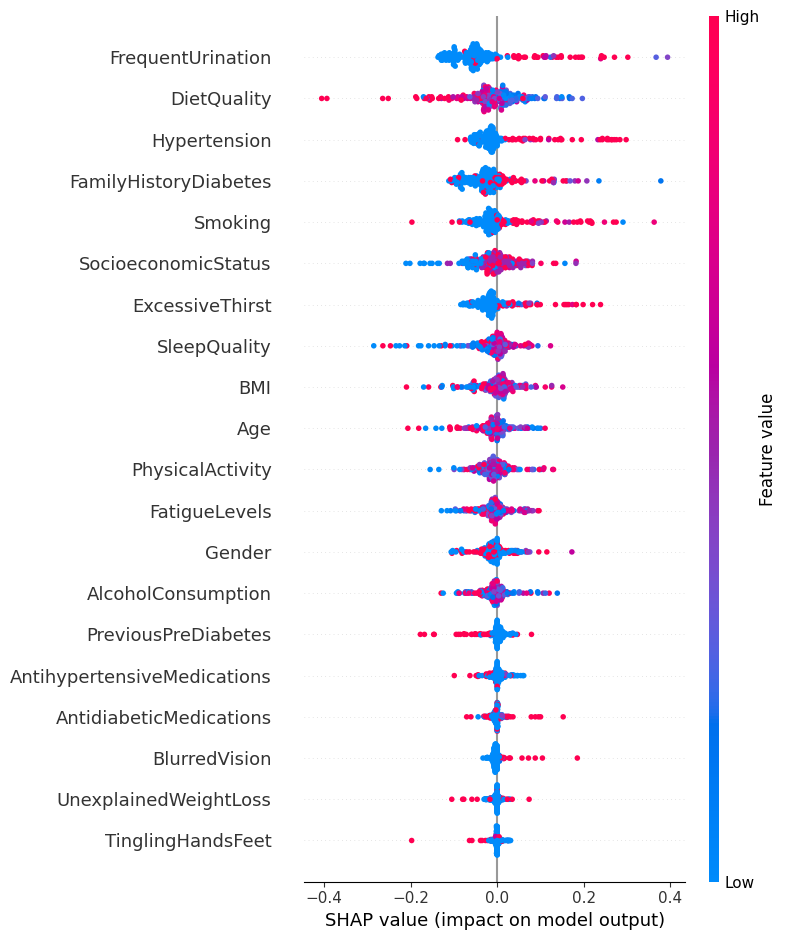

In [61]:
shap_values_class1 = shap_values[:,:,1]

shap.summary_plot(shap_values_class1, X_test)

In [78]:
#let's try seeing the values for an individual prediction using a force plot
index = 0
shap.value = explainer.shap_values(X_test.iloc[index:index+1])

shap_value_class1 = shap.value[0][:, 1]

shap_df = pd.DataFrame(shap_value_class1.reshape(1, -1), columns=X_test.columns)
shap_df.to_csv(f"shap_values_pred_{index}.csv", index=False)

shap_abs = shap_df.abs()
top_3_indices = shap_abs.iloc[0].nlargest(3).index.tolist()
top_3_df = shap_df[top_3_indices]

top_3_perc = (top_3_df/top_3_df.sum(axis=1).values.reshape(-1, 1))*100

top_3_perc.to_csv(f"/content/drive/MyDrive/KamiLimu/iPrevent/top_3_shap_values_pred_{index}.csv", index=False)

print(top_3_perc)

  0%|          | 0/1 [00:00<?, ?it/s]

   FrequentUrination  FatigueLevels        BMI
0          49.290202      25.847179  24.862619


## Pickling the model

I think at this point in time, we are free to pickle the model we can deploy it on Render

In [80]:
import joblib

joblib.dump(ada_rf, '/content/drive/MyDrive/KamiLimu/iPrevent/ada_rf_model.pkl')

['/content/drive/MyDrive/KamiLimu/iPrevent/ada_rf_model.pkl']